In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from keras.utils import to_categorical
from keras.models import Model, Sequential
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import h5py
from matplotlib import pyplot as plt
from PIL import Image
from time import time
import logging
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [3]:
ck_data = h5py.File('./CK_data.h5', 'r', driver='core')
X_data = np.expand_dims(np.asarray(ck_data['data_pixel']), axis=-1)
X_data = X_data.reshape((981,48*48))
y_data = np.asarray(ck_data['data_label'])
y_data = to_categorical(y_data)
n_classes = y_data.shape[1]

In [4]:
print(ck_data)

<HDF5 file "CK_data.h5" (mode r)>


In [5]:
print(X_data)

[[ 24  10  13 ... 150 153 156]
 [ 17  10  16 ... 151 153 156]
 [ 27  13  10 ... 148 152 156]
 ...
 [196 142 167 ...  59  56  42]
 [196 143 168 ...  59  56  41]
 [198 125 179 ...  59  54  40]]


In [6]:
print(y_data)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [7]:
print(n_classes)

7


In [8]:
print(y_data.shape[0])

981


In [9]:
X_train, X_validation, y_train, y_validation = train_test_split(X_data, y_data, test_size=0.2,random_state=0)

In [10]:
print('Training: ',X_train.shape)

Training:  (784, 2304)


In [11]:
print('Validation: ',X_validation.shape)

Validation:  (197, 2304)


In [12]:
#(PCA)
n_components = 10
pca =PCA(svd_solver='randomized',n_components=n_components,whiten=True).fit(X_train)
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_validation)

In [13]:
print(X_train_pca)

[[-1.44786504 -0.24529974  0.31113507 ... -2.50981537  1.9329027
  -0.81897791]
 [ 0.18164122  1.34082676  2.33828622 ... -1.30143692  1.53872449
   0.67341503]
 [-0.8023423   0.0669295   1.59699669 ... -0.58977066 -0.60882699
  -0.61808333]
 ...
 [ 0.16333901  0.6879411   0.40275641 ... -0.49326429 -1.62354395
  -0.0659776 ]
 [ 0.71147754 -1.09323005  0.46577083 ... -0.21683303 -0.51746331
   0.74180183]
 [ 1.3751698   0.14631636  2.12043461 ...  0.42140179  2.18194122
  -0.09272008]]


In [14]:
print(X_val_pca)

[[-0.86294939 -1.49200176  1.2759508  ...  1.06814639  0.13124404
  -0.36551294]
 [-1.88359735  1.39469406  0.02807465 ... -0.31727081 -1.32803116
   0.0508488 ]
 [-1.48972228  1.34759063 -0.53240475 ...  0.37663005 -0.73453566
   0.87902158]
 ...
 [-0.27925978 -0.59275815 -0.91364902 ...  0.17690649  0.60655316
   0.28582589]
 [ 0.0210476   0.32460672 -0.34817578 ...  1.02476111 -0.98869208
  -0.5595378 ]
 [ 0.82689775 -0.57126608  0.91926474 ... -0.50736344 -0.45749604
   0.61118504]]


In [15]:
print(X_train)

[[171 189 164 ...  35  42 109]
 [ 90 107 235 ...  88  96  77]
 [101 104  94 ...  77  77  77]
 ...
 [ 86  87  87 ...  89  89  88]
 [ 36  38  25 ...   1   3  10]
 [255 255 244 ...  23  19  13]]


In [16]:
eigenfaces = pca.components_.reshape((n_components, 48, 48))

In [17]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=3):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [18]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]

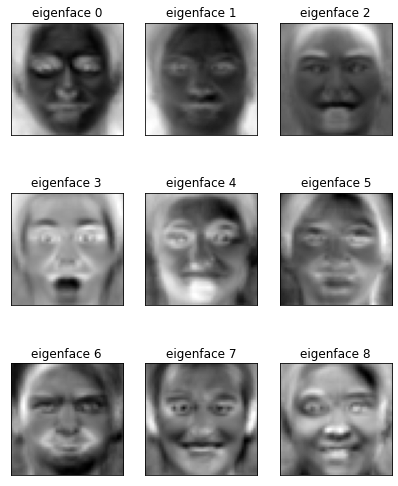

In [19]:
plot_gallery(eigenfaces, eigenface_titles, 48, 48)

In [20]:
plt.show()

In [21]:
y_train_ = np.argmax(y_train, axis=-1)

In [22]:
y_train_.shape

(784,)

In [23]:
print("Fitting the classifier to the training set")
t0 = time()

param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

#class_weight='balanced'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)

clf = clf.fit(X_train_pca, y_train_)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 6.598s
Best estimator found by grid search:
SVC(C=1000.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [24]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_val_pca)
print("done in %0.3fs" % (time() - t0))
y_val = np.argmax(y_validation, axis=-1)

print(classification_report(y_val, y_pred))

print(confusion_matrix(y_val, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.007s
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       0.97      1.00      0.99        34
           2       1.00      0.81      0.90        16
           3       0.95      1.00      0.98        41
           4       0.94      1.00      0.97        15
           5       1.00      0.97      0.98        58
           6       1.00      1.00      1.00        13

    accuracy                           0.97       197
   macro avg       0.97      0.97      0.97       197
weighted avg       0.98      0.97      0.97       197

[[20  0  0  0  0  0  0]
 [ 0 34  0  0  0  0  0]
 [ 1  0 13  2  0  0  0]
 [ 0  0  0 41  0  0  0]
 [ 0  0  0  0 15  0  0]
 [ 0  1  0  0  1 56  0]
 [ 0  0  0  0  0  0 13]]
